## **ENEL 525 - Final Project**

#### **Importing Libraries**

In [1]:
import os
import random
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

import tensorflow as tf

#### **Count the Number of Files in Each Class**

In [2]:
directory_path = 'flowers'

flowers_label = []
files_sub = []

for subdir in os.listdir(directory_path):
    subdirectory = os.path.join(directory_path, subdir)
    flowers_label.append(subdir)

    if os.path.isdir(subdirectory):
        num_files = len(os.listdir(subdirectory))
        files_sub.append(num_files)

        print(f"Subdirectory '{subdir}' contains {num_files} files.")

Subdirectory 'daisy' contains 764 files.
Subdirectory 'dandelion' contains 1052 files.
Subdirectory 'rose' contains 784 files.
Subdirectory 'sunflower' contains 733 files.
Subdirectory 'tulip' contains 984 files.


#### **Distribution of Number of Files in Each Class**

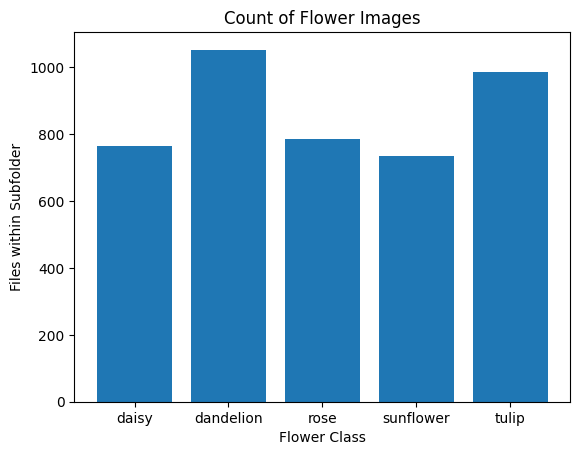

In [3]:
plt.bar(flowers_label, files_sub)

plt.title('Count of Flower Images')
plt.xlabel('Flower Class')
plt.ylabel('Files within Subfolder')

plt.show()

#### **Creating the NumPy Arrays for the Dataset**

In [4]:
images=[]
labels=[]

for subfolder in os.listdir('flowers'):
    subfolder_path = os.path.join('flowers', subfolder)

    # Get the label from the subfolder name
    if os.path.isdir(subfolder_path):
        label = subfolder

        # Iterate through the image files in the subfolder
        for image_file in os.listdir(subfolder_path):
            image_path = os.path.join(subfolder_path, image_file)

            image = cv2.imread(image_path) # Read the image using OpenCV

            # Perform any preprocessing on the image - resizing & normalizing
            image = cv2.resize(image, (128, 128))
            image = image.astype('float32') / 255.0

            # Append the image and label to the lists
            images.append(image)
            labels.append(label)

# Convert the lists to NumPy arrays
images = np.array(images)
labels = np.array(labels)

print(images)
print(labels)

[[[[0.5294118  0.5372549  0.5372549 ]
   [0.5686275  0.5686275  0.5686275 ]
   [0.58431375 0.5803922  0.5803922 ]
   ...
   [0.5921569  0.6        0.6       ]
   [0.59607846 0.6039216  0.6039216 ]
   [0.6039216  0.6039216  0.6039216 ]]

  [[0.52156866 0.5294118  0.5294118 ]
   [0.56078434 0.5647059  0.5647059 ]
   [0.5764706  0.5764706  0.5764706 ]
   ...
   [0.59607846 0.6039216  0.6039216 ]
   [0.5921569  0.6        0.6       ]
   [0.5921569  0.5921569  0.5921569 ]]

  [[0.5058824  0.52156866 0.5254902 ]
   [0.54509807 0.5529412  0.5568628 ]
   [0.56078434 0.5686275  0.57254905]
   ...
   [0.60784316 0.6117647  0.6117647 ]
   [0.5882353  0.59607846 0.59607846]
   [0.5803922  0.5803922  0.5803922 ]]

  ...

  [[0.09803922 0.18039216 0.16862746]
   [0.09803922 0.18039216 0.16862746]
   [0.09803922 0.18039216 0.16862746]
   ...
   [0.4862745  0.49019608 0.5058824 ]
   [0.48235294 0.4862745  0.5019608 ]
   [0.49019608 0.49411765 0.50980395]]

  [[0.10196079 0.18431373 0.17254902]
   [0.1

#### **One-Hot Encoded the Label**

In [5]:
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
encoded_labels = encoded_labels.reshape(-1, 1)  # Reshape to a column vector

uni_labels = np.array(['daisy', 'dandelion', 'rose', 'sunflower', 'tulip'])

label_map = pd.DataFrame([0, 1, 2, 3, 4], index = uni_labels, columns = ['Class Code'])
print('Class Mapping:')
print(label_map)

# One-hot encode the labels
onehot_encoder = OneHotEncoder(sparse=False)
onehot_encoded_labels = onehot_encoder.fit_transform(encoded_labels)

uni_encoded_labels = np.array([[1, 0, 0, 0, 0], [0, 1, 0, 0, 0], [0, 0, 1, 0, 0], [0, 0, 0, 1, 0], [0, 0, 0, 0, 1]])

label_map = pd.DataFrame(uni_encoded_labels, index = uni_labels, columns = uni_labels)
print('\nOne-Hot Encoded Class Mapping:')
print(label_map)

Class Mapping:
           Class Code
daisy               0
dandelion           1
rose                2
sunflower           3
tulip               4

One-Hot Encoded Class Mapping:
           daisy  dandelion  rose  sunflower  tulip
daisy          1          0     0          0      0
dandelion      0          1     0          0      0
rose           0          0     1          0      0
sunflower      0          0     0          1      0
tulip          0          0     0          0      1


#### **Split the Data into Train, Test, and Validation Sets (70-15-15)**

In [6]:
train_images, test_images, train_labels, test_labels = train_test_split(images, onehot_encoded_labels, test_size = 0.3, random_state = 42) # 70-30 split
test_images, val_images, test_labels, val_labels = train_test_split(test_images, test_labels, test_size = 0.5, random_state = 42)          # 50-50 split of the 30

# Create TensorFlow Datasets from NumPy arrays
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))

In [7]:
train_df_size = tf.data.experimental.cardinality(train_dataset).numpy()
test_df_size = tf.data.experimental.cardinality(test_dataset).numpy()
val_df_size = tf.data.experimental.cardinality(val_dataset).numpy()

print('Size of the training dataset: ', train_df_size)
print('Size of the testing dataset: ', test_df_size)
print('Size of the validation dataset: ', val_df_size)

Size of the training dataset:  3021
Size of the testing dataset:  648
Size of the validation dataset:  648


#### **Viewing Images in the Training Dataset**

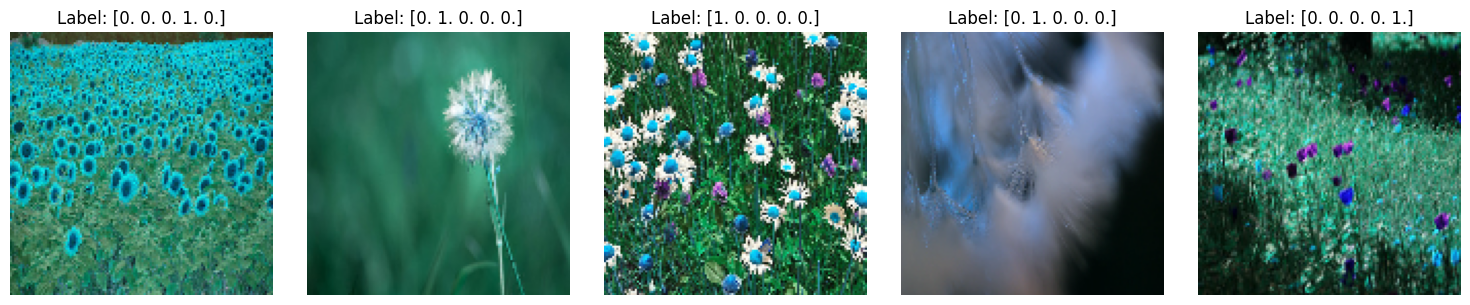

[3 1 0 1 4]


In [8]:
num_images_to_visualize = 5  # Number of images to visualize

# Take the first `num_images_to_visualize` from the training dataset
images_to_show = []
labels_to_show = []

for image, label in train_dataset.take(num_images_to_visualize):
    # Convert TensorFlow tensor to NumPy array
    image_np = image.numpy()
    label_np = label.numpy()

    # Store images and labels in lists
    images_to_show.append(image_np)
    labels_to_show.append(label_np)

# Plot multiple images in a single line using Matplotlib
plt.figure(figsize=(15, 3))  # Set figure size to accommodate multiple images

for i in range(num_images_to_visualize):
    plt.subplot(1, num_images_to_visualize, i + 1)
    plt.imshow(images_to_show[i], cmap = 'gray')  # Show the image in grayscale
    plt.title(f"Label: {labels_to_show[i]}")
    plt.axis('off')  # Hide axis labels

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

# Convert each one-hot encoded array to a single integer
converted_labels = np.argmax(labels_to_show, axis = 1)
print(converted_labels)

#### **Viewing Images in the Testing Dataset**

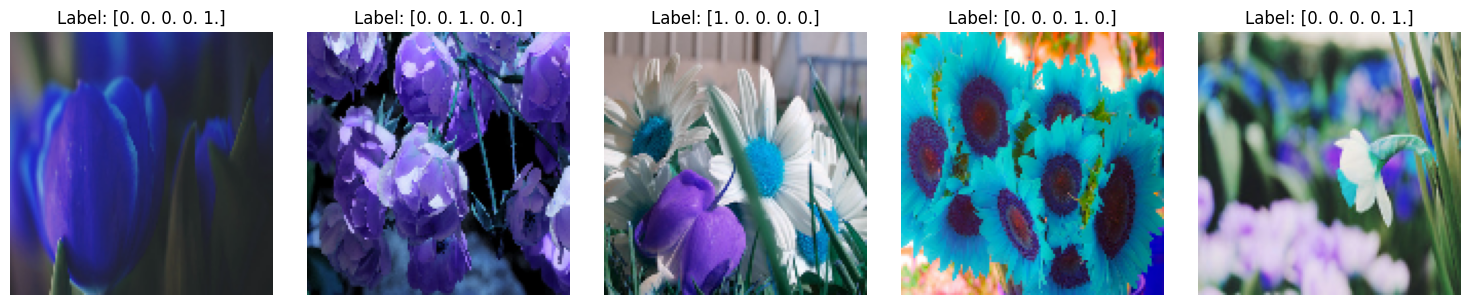

[4 2 0 3 4]


In [9]:
num_images_to_visualize = 5  # Number of images to visualize

# Take the first `num_images_to_visualize` from the training dataset
images_to_show = []
labels_to_show = []

for image, label in test_dataset.take(num_images_to_visualize):
    # Convert TensorFlow tensor to NumPy array
    image_np = image.numpy()
    label_np = label.numpy()

    # Store images and labels in lists
    images_to_show.append(image_np)
    labels_to_show.append(label_np)

# Plot multiple images in a single line using Matplotlib
plt.figure(figsize=(15, 3))  # Set figure size to accommodate multiple images

for i in range(num_images_to_visualize):
    plt.subplot(1, num_images_to_visualize, i + 1)
    plt.imshow(images_to_show[i], cmap = 'gray')  # Show the image in grayscale
    plt.title(f"Label: {labels_to_show[i]}")
    plt.axis('off')  # Hide axis labels

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

# Convert each one-hot encoded array to a single integer
converted_labels = np.argmax(labels_to_show, axis = 1)
print(converted_labels)

#### **Viewing Images in the Validation Dataset**

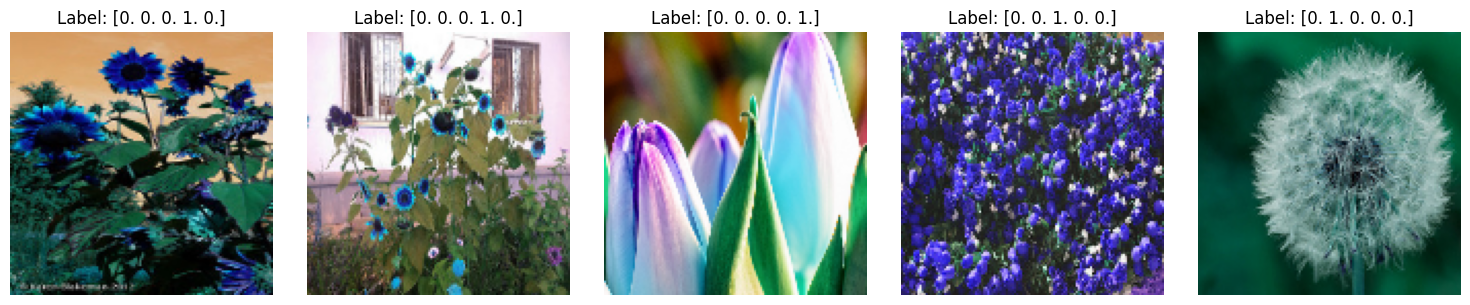

[3 3 4 2 1]


In [10]:
num_images_to_visualize = 5  # Number of images to visualize

# Take the first `num_images_to_visualize` from the training dataset
images_to_show = []
labels_to_show = []

for image, label in val_dataset.take(num_images_to_visualize):
    # Convert TensorFlow tensor to NumPy array
    image_np = image.numpy()
    label_np = label.numpy()
    
    # Store images and labels in lists
    images_to_show.append(image_np)
    labels_to_show.append(label_np)

# Plot multiple images in a single line using Matplotlib
plt.figure(figsize=(15, 3))  # Set figure size to accommodate multiple images

for i in range(num_images_to_visualize):
    plt.subplot(1, num_images_to_visualize, i + 1)
    plt.imshow(images_to_show[i], cmap = 'gray')  # Show the image in grayscale
    plt.title(f"Label: {labels_to_show[i]}")
    plt.axis('off')  # Hide axis labels

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

# Convert each one-hot encoded array to a single integer
converted_labels = np.argmax(labels_to_show, axis = 1)
print(converted_labels)

#### **Normalizing the Images**

In [11]:
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

train_dataset = train_dataset.map(normalize_img, num_parallel_calls = tf.data.AUTOTUNE)

train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(100)
train_dataset = train_dataset.batch(128)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

#### **Build an Evaluation Pipeline**

In [12]:
test_dataset = test_dataset.map(normalize_img, num_parallel_calls = tf.data.AUTOTUNE)

test_dataset = test_dataset.batch(128)
test_dataset = test_dataset.cache()
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

In [13]:
val_dataset = val_dataset.map(normalize_img, num_parallel_calls = tf.data.AUTOTUNE)

val_dataset = val_dataset.batch(128)
val_dataset = val_dataset.cache()
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

#### **Creating and Training the Model**

In [14]:
# Real-time data augmentation during model training on image data
datagen = ImageDataGenerator(
    rotation_range = 20,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest')

In [15]:
# Creating the Model
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape = (128, 128,3)),                                      # images of size 128x128 with three color channels (RGB)
    tf.keras.layers.Conv2D(filters = 32, kernel_size = (3, 3), activation = "relu"),  # first convolutional layer with 32 filters
    tf.keras.layers.MaxPooling2D((2, 2)),                                             # downsample the feature maps obtained from the convolutional layer
    tf.keras.layers.Conv2D(filters = 64, kernel_size = (3, 3), activation = "relu"),  # second convolutional layer with 64 filters
    tf.keras.layers.MaxPooling2D((2, 2)),                                             # downsample the feature maps obtained from the convolutional layer
    tf.keras.layers.Conv2D(filters = 128, kernel_size = (3, 3), activation = "relu"), # third convolutional layer with 128 filters
    tf.keras.layers.MaxPooling2D((2, 2), strides = (2, 2)),                           # downsample the feature maps obtained from the convolutional layer
    tf.keras.layers.Flatten(),                                                        # flattens the output from the previous layer into a 1D array to be fed into the dense layers
    tf.keras.layers.Dense(256, activation = "relu"),                                  # fully connected layer with 256 neurons
    tf.keras.layers.Dense(5, activation = "softmax")                                  # 5 output neurons for the 5 classes
])

# Parameters to train the model and evaluate it
model.compile(optimizer = Adam(learning_rate = 0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Train the model
history = model.fit(
    datagen.flow(train_images, train_labels, batch_size = 32),
    epochs = 22,
    validation_data = (test_images, test_labels))

Epoch 1/22
95/95 [==============================] - 135s 1s/step - loss: 1.2844 - accuracy: 0.4459 - val_loss: 1.1518 - val_accuracy: 0.5293
Epoch 2/22
95/95 [==============================] - 111s 1s/step - loss: 1.0282 - accuracy: 0.5889 - val_loss: 1.0279 - val_accuracy: 0.5926
Epoch 3/22
95/95 [==============================] - 127s 1s/step - loss: 0.9754 - accuracy: 0.6111 - val_loss: 0.9928 - val_accuracy: 0.6281
Epoch 4/22
95/95 [==============================] - 127s 1s/step - loss: 0.8936 - accuracy: 0.6531 - val_loss: 0.9023 - val_accuracy: 0.6466
Epoch 5/22
95/95 [==============================] - 109s 1s/step - loss: 0.8279 - accuracy: 0.6792 - val_loss: 0.7991 - val_accuracy: 0.6836
Epoch 6/22
95/95 [==============================] - 127s 1s/step - loss: 0.7779 - accuracy: 0.6958 - val_loss: 0.9377 - val_accuracy: 0.6327
Epoch 7/22
95/95 [==============================] - 118s 1s/step - loss: 0.7766 - accuracy: 0.6978 - val_loss: 0.8558 - val_accuracy: 0.6867
Epoch 8/22
95

#### **Model Summary**

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 128)      0

#### **Plotting the Training and Validation Loss over Epochs**

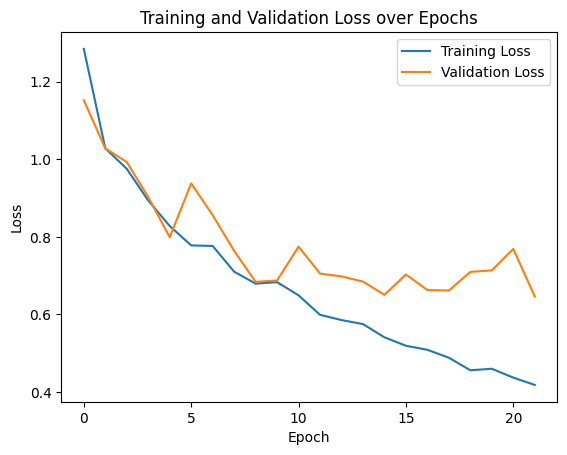

In [18]:
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.title('Training and Validation Loss over Epochs')
plt.legend()

plt.show()

#### **Plotting the Training and Validation Accuracy over the Epochs**

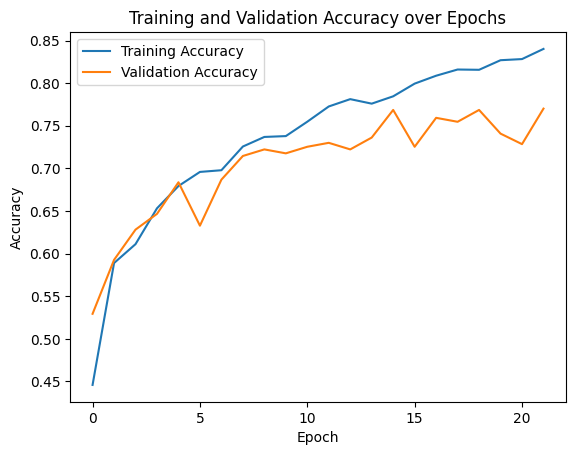

In [31]:
plt.plot(history.history['accuracy'], label = 'Training Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.title('Training and Validation Accuracy over Epochs')
plt.legend()

plt.show()

#### **Predict Labels for Test Images**

In [19]:
predictions = model.predict(test_images)
print('Predictions: \n', predictions)

# Convert each one-hot encoded array to a single integer
predicted_labels = np.argmax(predictions, axis = 1)

print('\nPredicted Labels: \n', predicted_labels)

21/21 [==============================] - 3s 128ms/step
Predictions: 
 [[3.1979445e-03 1.5513416e-04 2.9911786e-01 2.2821834e-05 6.9750619e-01]
 [2.7983175e-03 5.0767405e-05 5.1471561e-01 4.1445182e-05 4.8239383e-01]
 [7.8748178e-01 7.6819284e-05 1.6267848e-01 7.7941880e-04 4.8983529e-02]
 ...
 [2.0204645e-01 2.5163269e-01 8.7563640e-06 3.7248546e-01 1.7382653e-01]
 [1.1870970e-03 4.6669338e-03 7.9471342e-02 1.5528186e-04 9.1451937e-01]
 [6.5193534e-02 9.2355657e-01 4.1539515e-03 2.9828041e-04 6.7977416e-03]]

Predicted Labels: 
 [4 2 0 3 4 3 1 2 0 0 1 4 0 1 3 0 3 4 3 4 4 0 0 2 2 4 3 1 1 4 3 4 3 4 1 1 2
 4 0 0 0 3 1 3 1 1 2 3 4 4 1 1 3 2 3 1 0 0 0 3 1 1 3 4 2 2 0 2 0 1 4 3 2 4
 1 1 2 1 4 4 4 3 2 4 0 0 1 1 0 0 1 3 2 1 4 1 2 0 2 2 3 4 2 4 1 0 1 3 2 1 4
 1 4 0 3 0 1 0 0 4 3 3 4 0 3 4 1 0 4 2 0 0 0 0 3 4 1 0 4 4 4 0 3 4 4 2 3 4
 4 2 1 1 1 4 2 0 4 2 1 0 1 3 3 0 4 3 4 1 1 0 4 1 2 1 4 4 2 4 0 1 1 4 1 2 3
 0 1 0 0 1 3 1 1 3 3 4 2 0 2 1 2 1 0 1 0 4 0 4 2 0 2 4 1 1 0 1 1 4 4 2 4 2
 4 3 3 2 2 0 2 

#### **Confusion Matrix**

(648, 5)


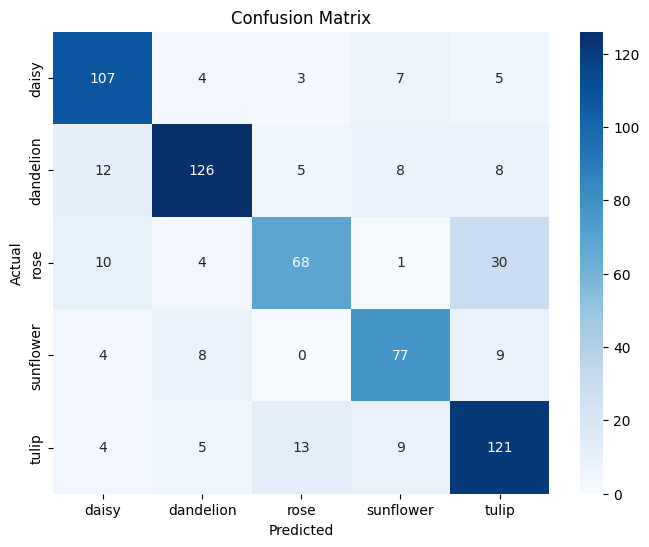

In [20]:
true_labels = []
for _, label in test_dataset:
    true_labels.extend(label.numpy())
    true_labels_array = np.array(true_labels)

print(true_labels_array.shape)

# Flatten the arrays to get a 1D representation for each sample
flat_predicted = np.argmax(predictions, axis=1)
flat_true = np.argmax(true_labels_array, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(flat_true, flat_predicted)

# Create a heatmap using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot = True, cmap = 'Blues', fmt = 'g', 
            xticklabels = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip'], 
            yticklabels = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip'])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

plt.show()

#### **Displaying the Images with their Actual and Predicted Labels**

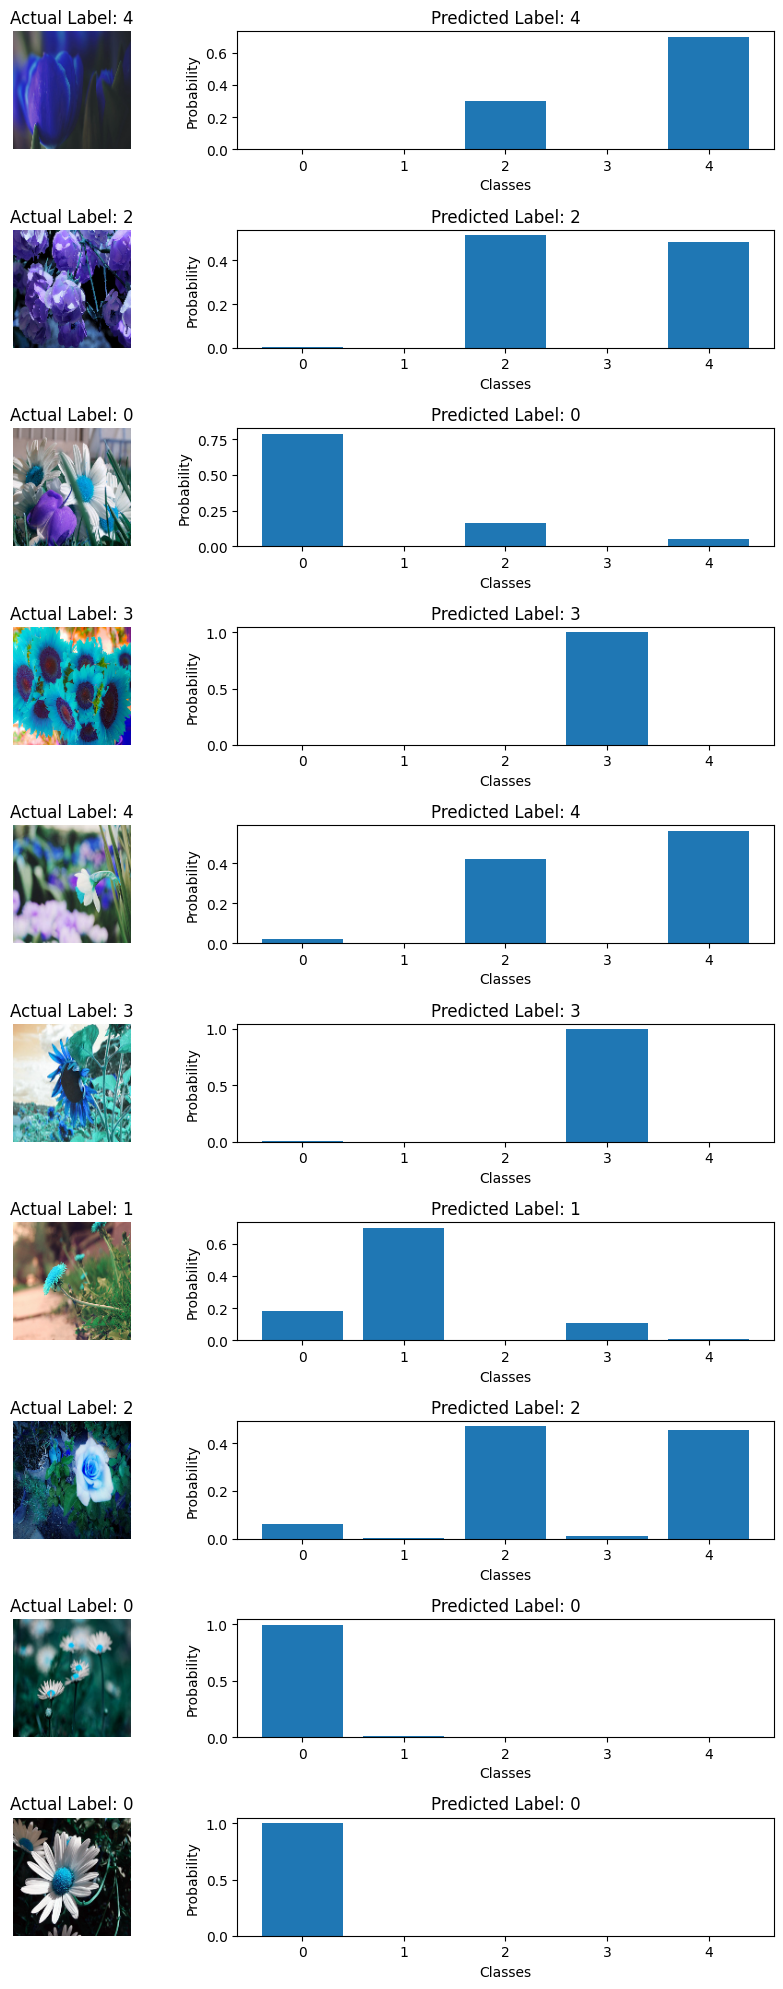

In [21]:
num_images_to_display = 10

plt.figure(figsize=(10, 20))

for i in range(num_images_to_display):
    plt.subplot(num_images_to_display, 2, i * 2 + 1)
    plt.imshow(test_images[i], cmap='gray')  # Assuming test images are grayscale
    plt.title(f"Actual Label: {predicted_labels[i]}")
    plt.axis('off')

    plt.subplot(num_images_to_display, 2, i * 2 + 2)
    plt.bar(np.arange(5), predictions[i])  # Bar plot for predicted labels
    plt.title(f"Predicted Label: {predicted_labels[i]}")
    plt.xlabel("Classes")
    plt.ylabel("Probability")
    plt.xticks(np.arange(5))  # Assuming 5 classes
    plt.tight_layout()

plt.show()

#### **Evaluate the Model Train Loss & Accuracy**

In [32]:
train_loss, train_acc = model.evaluate(train_images, train_labels, verbose=2)
print("\nTrain loss: ", train_loss)
print("Train accuracy: ", train_acc* 100, '%')

95/95 - 8s - loss: 0.2657 - accuracy: 0.9106 - 8s/epoch - 87ms/step

Train loss:  0.26571565866470337
Train accuracy:  91.06256365776062 %


#### **Evaluate the Model Validation Loss & Accuracy**

In [34]:
val_loss, val_acc = model.evaluate(val_images, val_labels, verbose=2)
print("\nValidation loss: ", val_loss)
print("Validation accuracy: ", val_acc* 100, '%')

21/21 - 2s - loss: 0.7326 - accuracy: 0.7840 - 2s/epoch - 77ms/step

Validation loss:  0.7326184511184692
Validation accuracy:  78.39506268501282 %


#### **Evaluate the Model Test Loss & Accuracy**

In [22]:
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print("\nTest loss: ", test_loss)
print("Test accuracy: ", test_acc* 100, '%')

21/21 - 4s - loss: 0.6463 - accuracy: 0.7701 - 4s/epoch - 211ms/step

Test loss:  0.6463199853897095
Test accuracy:  77.0061731338501 %
